In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import glob
import tensorflow.keras.datasets.mnist as mnist

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])

In [3]:
# 读取数据
(x_train,y_train),(x_test,_)=tf.keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape,x_train.dtype)

# 转换数据类型
x_train=((x_train.astype('float32')-127.5)/127.5).reshape(x_train.shape[0],28,28,1)
print(x_train.shape)

#  定义datasets
batch_szie=256
shuffle_size=x_train.shape[0]
noise_dim=50

datasets=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(shuffle_size).batch(batch_szie)
datasets = datasets.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Dataset.prefetch() 方法，使得我们可以让数据集对象 Dataset 在训练时预取出若干个元素，
# 使得在 GPU 训练的同时 CPU 可以准备数据，从而提升训练流程的效率
# 使用方法和Dataset.batch() 、 Dataset.shuffle() 等非常类似

(60000, 28, 28) (60000,) uint8
(60000, 28, 28, 1)


In [4]:
def generator_model():
    seed=layers.Input(shape=((noise_dim,)))
    label=layers.Input(shape=(()))
    
    x=layers.Embedding(10,50,input_length=1)(label)  # 标签信息embeding,# x.shape=(batch_size,seq_len.embeddign)
    x=layers.Flatten()(x)  # x.shape=(batch_size,50*1)
    x=layers.concatenate([seed,x])  # 将标签信息和数据信息融合
    
    x=layers.Dense(3*3*128,use_bias=False)(x)
    x=layers.Reshape((3,3,128))(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    
    x=layers.Conv2DTranspose(64,(3,3),strides=(2,2),use_bias=False)(x) # (7,7,64)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    
    x=layers.Conv2DTranspose(32,(3,3),strides=(2,2),
                             padding='same',use_bias=False)(x) # (14,14,32)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    
    x=layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',
                             use_bias=False,activation='tanh')(x) # (28,28,1)
    
    model=tf.keras.Model(inputs=[seed,label],outputs=x)
    
    return model


def discriminator_model():
    
    image=layers.Input(shape=((28,28,1)))
    label=layers.Input(shape=(()))
    
    x=layers.Embedding(10,28*28,input_length=1)(label)
    x=layers.Reshape((28,28,1))(x)
    x=layers.concatenate([image,x])
    
    x=layers.Conv2D(32,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dropout(0.5)(x)
    
    x=layers.Conv2D(32*2,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dropout(0.5)(x)
    
    x=layers.Conv2D(32*4,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dropout(0.5)(x)
    
    x=layers.Flatten()(x)
    x1=layers.Dense(1)(x)
    
    model=tf.keras.Model(inputs=[image,label],outputs=x1)
    return model

In [5]:
# 损失
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
category_cross_entropy=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def discriminator_loss(real_image,fake_image):
    real_loss=cross_entropy(tf.ones_like(real_image),real_image)
    fake_loss=cross_entropy(tf.zeros_like(fake_image),fake_image)    
    return real_loss+fake_loss

def generator_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image),fake_image)

# 优化器
generator_opti=tf.keras.optimizers.Adam(1e-4)
discriminator_opti=tf.keras.optimizers.Adam(1e-4)
f
# 参数
noise_dim = 50 # 输入G中的初始向量长度。
num = 10 # test的样本数
test_noise = tf.random.normal([num, noise_dim])
test_label = np.random.randint(0, 10, size=(num, 1)) # label，引导G生成的目标数据
print(test_label.T) # 

# 函数生成
generator=generator_model()
discriminator=discriminator_model()

[[4 0 0 8 9 7 6 6 1 3]]


In [6]:
tf.config.run_functions_eagerly(True)

@tf.function  # 函数修饰器,将用户定义的python风格的函数代码转化成高效的tensorflow计算图
                # 可以加速网络的推理速度,还能够有效降低占用显卡显存,使低显存的显卡也可以跑大网络
def train_step(images,labels):
    batchsize=labels.shape[0]
    noise=tf.random.normal([batchsize,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image=generator((noise,labels),training=True)    # 输入噪声去生成图像并判别
        
        real_out=discriminator((images,labels),training=True) # 输入真实图像去判别
        fake_out=discriminator((gen_image,labels),training=True)
        
        gen_loss=generator_loss(fake_out)
        disc_loss=discriminator_loss(real_out,fake_out)
        
    gradient_gen=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_disc=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_opti.apply_gradients(zip(gradient_gen,generator.trainable_variables))
    discriminator_opti.apply_gradients(zip(gradient_disc,discriminator.trainable_variables))
    return gen_loss,disc_loss

In [7]:
def generator_plot_image(gen_model,test_noise,test_label):  # 
    pred_images=gen_model((test_noise,test_label),training=False) # 查看利用噪声数据生成出16的图像
    pred_images=tf.squeeze(pred_images)
    
    fig=plt.figure(figsize=(7,9))
    for i in range(pred_images.shape[0]):
        plt.subplot(1,10,i+1)
        plt.imshow((pred_images[i,:,:]+1)/2) # 画出利用噪声数据gen出的图像
        plt.axis('off')
    plt.show()

In [8]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')
g_loss_results = []
d_loss_results = []

def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch ,label_batch in dataset:
            # 训练
            g_loss, d_loss = train_step(image_batch,label_batch)
            # 计算每个epoch的平均loss
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
            print('.',end='')
        # 记录每个epoch的loss
        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states() # 将loss的buffer清除掉
        epoch_loss_avg_disc.reset_states()
        
        if epoch%5==0:
            # 画noise生成的图
            generator_plot_image(generator,test_noise,test_label)
        print('将开始第{}轮epoch'.format(epoch+1))

...........................................................................................................................................................................................................................................

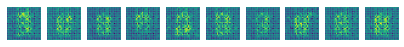

将开始第1轮epoch
....................................................................................................................................................................................................

KeyboardInterrupt: 

In [9]:
import time
result1=time.time()
epochs=100
train(datasets,epochs)
# [[8 7 8 7 7 6 0 7 9 5]]_noise_label
# 输出每轮训练时间
result2=time.time()
print('共训练了{}轮，每轮训练所用时间为{},总用时为{}'
      .format(epochs,(result2-result1)/(epochs),result2-result1))